In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# HELPER FUNCTIONS

In [8]:
def clean_data(movies_file, data_file):
    unique_title_id_map = {}  # to keep track of titles that already have an id
    needed_updates = {}  # this array will map ids that need to be changed to the id
    # they should be changed to
    with open(movies_file, 'r') as f:
        for line in f:
            line_data = line.strip('\n').split('\t')
            movie_id, title = line_data[0], line_data[1]
            if str(title) in unique_title_id_map:
                needed_updates[movie_id] = unique_title_id_map[str(title)]
            else:
                unique_title_id_map[str(title)] = str(movie_id)
    # print(needed_updates)

    data_arr = np.loadtxt(data_file, dtype=np.int)
    for i, row in enumerate(data_arr):
        if str(row[1]) in needed_updates:
            data_arr[i, 1] = needed_updates[str(row[1])]
    return (data_arr)

In [9]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

#movie_cols = ['Movie ID','Movie Title', 'Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
#'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

data_arr = clean_data('data/movies.txt','data/data.txt')

# Basic Method

In [10]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * np.subtract(reg * Ui, (Yij - np.dot(Ui, Vj))* Vj)

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * np.subtract(reg * Vj, (Yij - np.dot(Ui, Vj))* Ui)

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T
    
    sum = 0.0
    for x in range(len(Y)):
        i = Y[x, 0] - 1
        j = Y[x, 1] - 1
        Yij = Y[x, 2]
        sum += (Yij - np.dot(U[i], V[j]))**2
    return reg / 2 * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2) + 0.5 * sum"""
    N,D = Y.shape
    err = 0
    
    for n in range(N):
        i = Y[n,0] - 1
        j = Y[n,1] - 1
        yij = Y[n,2]
        err += (yij - np.dot(U[i], V[j]))**2
        
    U_norm = np.linalg.norm(U)
    V_norm = np.linalg.norm(V)
    
    return (reg/2 *(U_norm**2 + V_norm**2) + err/2) / N


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    a, b = -0.5, 0.5
    U = (b - a) * np.random.random_sample((M, K)) + a
    V = (b - a) * np.random.random_sample((N, K)) + a
    
    # first iteration, get loss reduction for initial epoch
    err0 = get_err(U, V, Y)
    arr = np.arange(len(Y))
    np.random.shuffle(arr)
    for index in arr:
        i = Y[index, 0] - 1
        j = Y[index, 1] - 1
        Yij = Y[index, 2]
        U[i] -= grad_U(U[i], Yij, V[j], reg, eta)
        V[j] -= grad_V(V[j], Yij, U[i], reg, eta)
    err01 = err0 - get_err(U, V, Y)
    
    # second through last iterations
    for epoch in range(max_epochs - 1):
        last_err = get_err(U, V, Y)
        arr = np.arange(len(Y))
        np.random.shuffle(arr)
        for index in arr:
            i = Y[index, 0] - 1
            j = Y[index, 1] - 1
            Yij = Y[index, 2]
            U[i] -= grad_U(U[i], Yij, V[j], reg, eta)
            V[j] -= grad_V(V[j], Yij, U[i], reg, eta)
        curr_err = get_err(U, V, Y)
        if (last_err - curr_err) / err01 < eps:
            last_err = curr_err
            break
        last_err = curr_err
    return (U, V, last_err)

# Bias Term Method

In [39]:
def bgrad_U(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate), ai (the bias term for user), bj (bias 
    term for movie), mu (the average of Y)

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * np.subtract(reg * Ui, (Yij - mu - np.dot(Ui, Vj) - ai - bj)* Vj)

def bgrad_V(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate), ai (the bias term for user), bj (bias 
    term for movie), mu (the average of Y)

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * np.subtract(reg * Vj, (Yij - mu - np.dot(Ui, Vj) - ai - bj)* Ui)

def bgrad_a(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate), ai (the bias term for user), bj (bias 
    term for movie), mu (the average of Y)

    Returns the gradient of the regularized loss function with
    respect to ai multiplied by eta.
    """
    return eta * (reg * ai - Yij + mu + np.dot(Ui, Vj) + ai + bj)

def bgrad_b(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate), ai (the bias term for user), bj (bias 
    term for movie), mu (the average of Y)

    Returns the gradient of the regularized loss function with
    respect to bj multiplied by eta.
    """
    return eta * (reg * bj - Yij + mu + np.dot(Ui, Vj) + ai + bj)

def bget_err(Y, U, V, reg, a, b, mu):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j, the
    user/movie matrices U and V, the bias vectors a and b, and the average observed rating mu

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T
    """
    sum = 0.0
    for x in range(len(Y)):
        i = Y[x, 0] - 1
        j = Y[x, 1] - 1
        Yij = Y[x, 2]
        sum += (Yij - mu - np.dot(U[i], V[j]) - a[i] - b[j])**2
    return reg / 2 * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2 + np.linalg.norm(a)**2 + np.linalg.norm(b)**2) + 0.5 * sum


def btrain_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, a, b, err) consisting of U, V, the bias vectors, and the MSE
    of the model.
    """
    a, b = -0.5, 0.5
    U = (b - a) * np.random.random_sample((M, K)) + a
    V = (b - a) * np.random.random_sample((N, K)) + a
    A = (b - a) * np.random.random_sample((M, 1)) + a # bias for user
    B = (b - a) * np.random.random_sample((N, 1)) + a # bias for movie
    mu = np.mean(Y[:, 2]) # average of all observed rating
    
    # first iteration, get loss reduction for initial epoch
    err0 = bget_err(Y, U, V, reg, A, B, mu)
    arr = np.arange(len(Y))
    np.random.shuffle(arr)
    for index in arr:
        i = Y[index, 0] - 1
        j = Y[index, 1] - 1
        Yij = Y[index, 2]
        Ui, Vj, Ai, Bj = U[i], V[j], A[i], B[j]
        U[i] -= bgrad_U(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        V[j] -= bgrad_V(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        A[i] -= bgrad_a(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        B[j] -= bgrad_b(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
    err01 = err0 - bget_err(Y, U, V, reg, A, B, mu)
    print(err01)

    # second through last iterations
    for epoch in range(max_epochs - 1):
        last_err = bget_err(Y, U, V, reg, A, B, mu)
        arr = np.arange(len(Y))
        np.random.shuffle(arr)
        for index in arr:
            i = Y[index, 0] - 1
            j = Y[index, 1] - 1
            Yij = Y[index, 2]
            Ui, Vj, Ai, Bj = U[i], V[j], A[i], B[j]
            U[i] -= bgrad_U(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
            V[j] -= bgrad_V(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
            A[i] -= bgrad_a(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
            B[j] -= bgrad_b(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        curr_err = bget_err(Y, U, V, reg, A, B, mu)
        print('change in err / initial = ' + str((last_err - curr_err) / err01))
        if (last_err - curr_err) / err01 < eps:
            last_err = curr_err
            break
        last_err = curr_err
    return (U, V, A, B, last_err)

def clean_data(movies_file, data_file):
    unique_title_id_map = {}  # to keep track of titles that already have an id
    needed_updates = {}  # this array will map ids that need to be changed to the id
    # they should be changed to
    with open(movies_file, 'r', encoding='utf-8') as f:
        for line in f:
            line_data = line.strip('\n').split('\t')
            movie_id, title = line_data[0], line_data[1]
            if str(title) in unique_title_id_map:
                needed_updates[movie_id] = unique_title_id_map[str(title)]
            else:
                unique_title_id_map[str(title)] = str(movie_id)
    # print(needed_updates)

    data_arr = np.loadtxt(data_file, dtype=np.int)
    for i, row in enumerate(data_arr):
        if str(row[1]) in needed_updates:
            data_arr[i, 1] = needed_updates[str(row[1])]
    return (data_arr)


# Basic Method Training

In [29]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

K = 20

reg = 0 #10**-3
eta = 0.03 # learning rate
E_in = 0
E_out = 0

# Use to compute Ein and Eout
U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)

# Bias Term Method Training

In [40]:

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20

reg = 0.1
eta = 0.03 # learning rate

print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
bU, bV, A, B, e_in = btrain_model(M, N, k, eta, reg, Y_train)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
[32985.50838478]
change in err / initial = [0.06400669]
change in err / initial = [0.03569161]
change in err / initial = [0.03725662]
change in err / initial = [0.03887852]
change in err / initial = [0.03653062]
change in err / initial = [0.03144848]
change in err / initial = [0.03102885]
change in err / initial = [0.02276395]
change in err / initial = [0.02248357]
change in err / initial = [0.01731583]
change in err / initial = [0.01878729]
change in err / initial = [0.01507368]
change in err / initial = [0.0114188]
change in err / initial = [0.01138594]
change in err / initial = [0.00913861]
change in err / initial = [0.01080905]
change in err / initial = [0.00583162]
change in err / initial = [0.00763676]
change in err / initial = [0.00379542]
change in err / initial = [0.00609468]
change in err / initial = [0.00503833]
change in err / initial = [0.00402473]
change in err / initial = [0.00501536]
change in err / in

In [ ]:
e_in /= len(Y_train)
e_out = get_err(Y_test, U, V, reg, A, B, np.mean(Y_test[:, 2]))/ len(Y_test)

In [ ]:
print('E_in is ' + str(e_in))
print('E_out is ' + str(e_out))

# Off the Shelf

In [48]:
import numpy as np
from scipy.sparse.linalg import svds

def off_train(M, N, Y):
    train_m = np.zeros((M,N))
    arr = np.arange(len(Y))

    for index in arr:
        i = Y[index, 0] - 1
        j = Y[index, 1] - 1
        Yij = Y[index,2]
        train_m[i][j] = Yij
        
    #U, s, V = svds(train_m, k = 20)
    U, s, V = np.linalg.svd(train_m)

    return U, s, V

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

K = 20

reg = 0 #10**-3
eta = 0.03 # learning rate
E_in = 0
E_out = 0

# Use to compute Ein and Eout
U_off, Sigma, V_off = off_train(M, N, Y_train)

# Find the average rating for each movie

In [21]:
movie_rating = np.zeros((1682,))
movie_num_user_rating = np.zeros((1682,))
for row in Y_train:
    # 0 is user id, 1 is movie id, 2 is rating
    movie_rating[row[1]-1] += row[2]
    movie_num_user_rating[row[1]-1] += 1
for row in Y_test:
    # 0 is user id, 1 is movie id, 2 is rating
    movie_rating[row[1]-1] += row[2]
    movie_num_user_rating[row[1]-1] += 1
movie_avg_rating = np.divide(np.array(movie_rating), np.array(movie_num_user_rating))
print(movie_avg_rating)

[3.87831858 3.20610687 3.03333333 ... 2.         3.         3.        ]


# Importing outside library AdjustText to make movie names not overlap

In [116]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7104 sha256=c4263acf1a0d03153ae0fe6a71ff16a917ac07de66488c34eadd3235078fb502
  Stored in directory: C:\Users\serena\AppData\Local\pip\Cache\wheels\41\95\74\7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


# Matrix Visualization with PC1 and PC2

In [25]:
from adjustText import adjust_text

def visualize_2d(M, title, index, marker_sz, **kwargs):
    """Project a matrix into 2 dimensions and visualize it.
    args: 
    M - matrix to project (V matrix)
    index - indices of the movies to project
    names - names of the movies for labeling

    """
    names = kwargs.get('names', None)
    
    A, sigma, B = np.linalg.svd(M)
    M_proj = np.matmul(A[:,:2].transpose(), M)
    
    cm = plt.cm.get_cmap('RdYlBu')
    
    sc = plt.scatter(M_proj[0,index], M_proj[1,index], s=marker_sz**2, vmin=0,vmax=5, c=movie_avg_rating[index], cmap=cm)
    if names != None:
        texts = []
        for i, name in zip(index, names):
            texts.append(plt.annotate(name, (M_proj[0, i], M_proj[1, i])))
        adjust_text(texts, autoalign='y')
    plt.colorbar(sc)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    return M_proj

# Basic All Movies

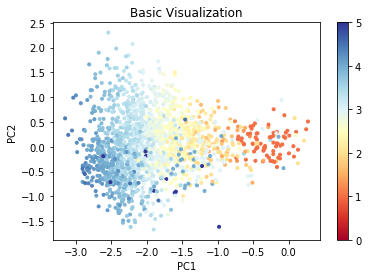

array([[-2.77240821, -2.1366022 , -2.03999763, ..., -0.44030291,
        -0.91240738, -0.96931671],
       [ 1.14030668,  0.57141901,  0.87178507, ...,  0.07297196,
         0.30603668, -0.47763089]])

In [26]:
index = range((V.T).shape[1])
title = 'Basic Visualization'
visualize_2d(V.T,title, index, 3)

# V-vector of all movies

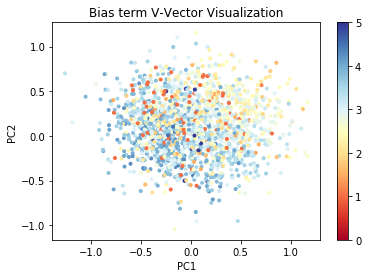

array([[ 0.01393449,  0.45263381,  0.21225774, ..., -0.13400777,
        -0.37313518,  0.16808487],
       [-0.13288461,  0.05326039,  0.36411833, ...,  0.0366133 ,
        -0.18325579, -0.0774266 ]])

In [42]:
index = range((bV.T).shape[1])
visualize_2d(bV.T, 'Bias term V-Vector Visualization',index, 3)

# Off the Shelf of All Movies

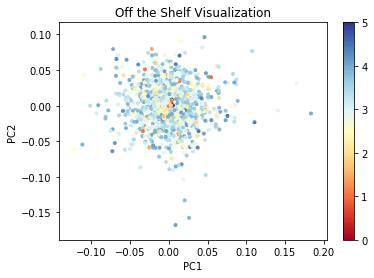

array([[ 3.19975166e-17, -6.81846868e-02,  7.63564244e-02, ...,
         2.49092379e-03, -4.92054703e-03, -1.94694697e-03],
       [ 1.02762037e-17,  1.69763209e-02,  3.23234102e-02, ...,
         3.67341793e-04,  6.49603545e-03,  3.95882009e-03]])

In [50]:
index = range((V_off.T).shape[1])
visualize_2d(V_off.T, 'Off the Shelf Visualization',index, 3)

# Get Movie Names

In [43]:
all_movies_names = []
with open('data/movies.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line_data = line.strip('\n').split('\t')
        all_movies_names.append(line_data[1])

def get_movie_names(index):
    chosen = []
    for i in index:
        chosen.append(all_movies_names[i])
    return chosen

# 10 randomly selected movies

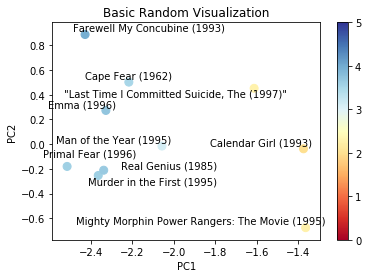

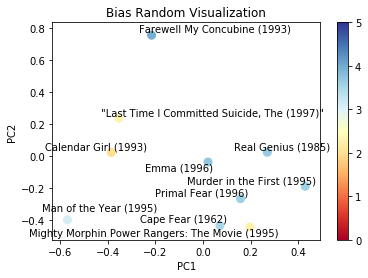

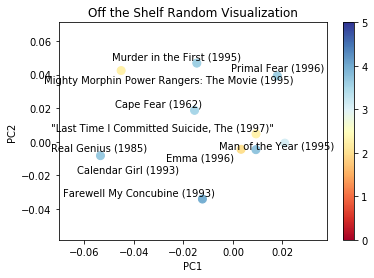

array([[ 3.19975166e-17, -6.81846868e-02,  7.63564244e-02, ...,
         2.49092379e-03, -4.92054703e-03, -1.94694697e-03],
       [ 1.02762037e-17,  1.69763209e-02,  3.23234102e-02, ...,
         3.67341793e-04,  6.49603545e-03,  3.95882009e-03]])

In [54]:
import random
    
num_movies = 1682
rand_index = np.random.choice(num_movies, 10, replace=False)
chosen_movie_names = get_movie_names(rand_index)
visualize_2d(V.T, 'Basic Random Visualization',rand_index, 8, names=chosen_movie_names)
visualize_2d(bV.T, 'Bias Random Visualization',rand_index, 8, names=chosen_movie_names)
visualize_2d(V_off.T, 'Off the Shelf Random Visualization',rand_index, 8, names=chosen_movie_names)

# Top 10 Most Popular Movies

Independence Day (ID4) (1996)
Air Force One (1997)
Toy Story (1995)
Scream (1996)
"English Patient, The (1996)"
Liar Liar (1997)
Return of the Jedi (1983)
Fargo (1996)
Contact (1997)
Star Wars (1977)


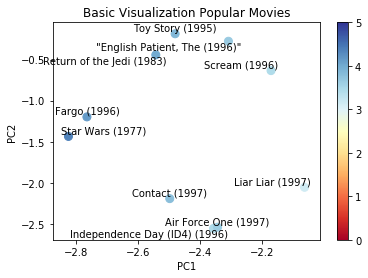

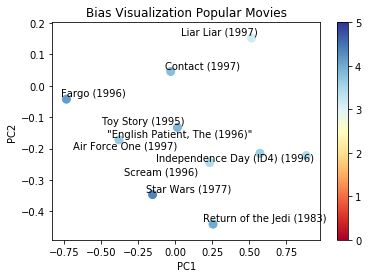

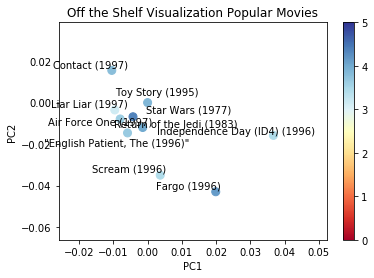

array([[ 3.19975166e-17, -6.81846868e-02,  7.63564244e-02, ...,
         2.49092379e-03, -4.92054703e-03, -1.94694697e-03],
       [ 1.02762037e-17,  1.69763209e-02,  3.23234102e-02, ...,
         3.67341793e-04,  6.49603545e-03,  3.95882009e-03]])

In [52]:
# index of top 10 by number of ratings
copy_num_rating = movie_num_user_rating.copy()
index_top10_popular = copy_num_rating.argsort()[-10:]
chosen_movie_names = get_movie_names(index_top10_popular)
for name in chosen_movie_names:
    print(name)
visualize_2d(V.T, 'Basic Visualization Popular Movies',index_top10_popular, 8, names=chosen_movie_names)
visualize_2d(bV.T, 'Bias Visualization Popular Movies',index_top10_popular, 8, names=chosen_movie_names)
visualize_2d(V_off.T, 'Off the Shelf Visualization Popular Movies',index_top10_popular, 8, names=chosen_movie_names)

# maybe need to include genre??

# Top 10 Best Movies by Ratings

Aiqing wansui (1994)
Santa with Muscles (1996)
Prefontaine (1997)
Marlene Dietrich: Shadow and Light (1996) 
Someone Else's America (1995)
They Made Me a Criminal (1939)
"Great Day in Harlem, A (1994)"
Entertaining Angels: The Dorothy Day Story (1996)
"Saint of Fort Washington, The (1993)"
Star Kid (1997)


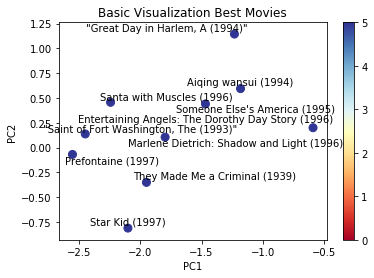

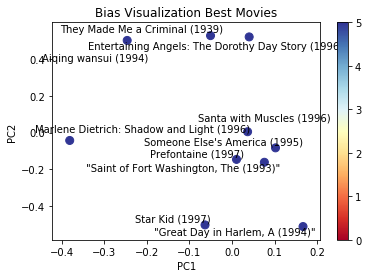

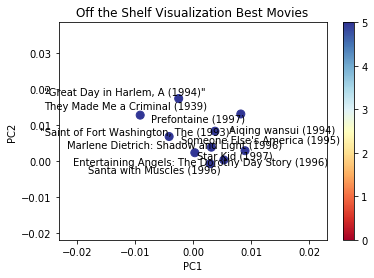

array([[ 3.19975166e-17, -6.81846868e-02,  7.63564244e-02, ...,
         2.49092379e-03, -4.92054703e-03, -1.94694697e-03],
       [ 1.02762037e-17,  1.69763209e-02,  3.23234102e-02, ...,
         3.67341793e-04,  6.49603545e-03,  3.95882009e-03]])

In [53]:
# index of top 10 by number of ratings
copy_avg_rating = movie_avg_rating.copy()
index_top10_rating = copy_avg_rating.argsort()[-10:]
chosen_movie_names = get_movie_names(index_top10_rating)
for name in chosen_movie_names:
    print(name)
visualize_2d(V.T,'Basic Visualization Best Movies', index_top10_rating, 8, names=chosen_movie_names)
visualize_2d(bV.T,'Bias Visualization Best Movies', index_top10_rating, 8, names=chosen_movie_names)
visualize_2d(V_off.T,'Off the Shelf Visualization Best Movies', index_top10_rating, 8, names=chosen_movie_names)

# maybe need to include genre??

# Selected Genre: 